In [5]:
from nipype.interfaces.ants import Registration
from nipype.interfaces.ants import ApplyTransforms
from nipype import Node, Workflow, MapNode
import nipype.interfaces.fsl as fsl
import nipype.interfaces.afni as afni
from nipype.interfaces.robex.preprocess import RobexSegment
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from os.path import join

def select_volume(filename, which):
    """Return the middle index of a file
    """
    from nibabel import load
    import numpy as np
    
    if which.lower() == 'first':
        idx = 0
    elif which.lower() == 'middle':
        idx = int(np.ceil(load(filename).shape[3]/2))
    else:
        raise Exception('unknown value for volume selection : %s'%which)
        
    return idx

def get_reg_wf(reg_type='func', name='func_reg_wf'): 
    """
    Return the registration workflow for direct EPI-to-template registration. 
    """
    # fetch input 
    inputnode = Node(IdentityInterface(fields=['in_file', 'template']),
                        name='inputnode')
    
    outputnode = Node(IdentityInterface(fields=['registered_image']), 
                        name='outputnode')
    
    extract_ref = Node(interface=fsl.ExtractROI(t_size=1),
                      name = 'extractref')
    
    # registration or normalization step based on symmetric diffeomorphic image registration (SyN) using ANTs 
    reg = Node(Registration(), name='NormalizationAnts')
    reg.inputs.output_transform_prefix = f'{reg_type}2template'
    reg.inputs.output_warped_image = f'{reg_type}2template.nii.gz'
    reg.inputs.output_transform_prefix = f'{reg_type}2template_'
    reg.inputs.transforms = ['Rigid','Affine', 'SyN']
    reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.2, 3.0, 0.0)]
    reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 2 + [[40, 10, 5]])
    reg.inputs.dimension = 3
    reg.inputs.write_composite_transform = True
    reg.inputs.collapse_output_transforms = True
    reg.inputs.initial_moving_transform_com = True
    reg.inputs.metric = ['Mattes'] * 2 + [['Mattes', 'CC']]
    reg.inputs.metric_weight = [1] * 2 + [[0.5, 0.5]]
    reg.inputs.radius_or_number_of_bins = [32] * 2 + [[32, 4]]
    reg.inputs.sampling_strategy = ['Regular'] * 2 + [[None, None]]
    reg.inputs.sampling_percentage = [0.3] * 2 + [[None, None]]
    reg.inputs.convergence_threshold = [1.e-8] * 2 + [-0.01]
    reg.inputs.convergence_window_size = [20] * 2 + [5]
    reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 2 + [[1, 0.5, 0]]
    reg.inputs.sigma_units = ['vox'] * 3
    reg.inputs.shrink_factors = [[3, 2, 1]]*2 + [[4, 2, 1]]
    reg.inputs.use_estimate_learning_rate_once = [True] * 3
    reg.inputs.use_histogram_matching = [False] * 2 + [True]
    reg.inputs.winsorize_lower_quantile = 0.005
    reg.inputs.winsorize_upper_quantile = 0.995
    reg.inputs.args = '--float'
    
    # apply the transform 
    apply_trans_func = Node(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    terminal_output='file'), 
                            name='apply_trans_func')
    
    reg_wf = Workflow(name=name, base_dir= output_dir)    

    if reg_type=='func':
        reg_wf.connect(
            [
                (inputnode, extract_ref, [('in_file', 'in_file'),
                                      (('in_file', select_volume, 'middle'), 't_min')]),
                (extract_ref, reg, [('roi_file', 'moving_image')]), 
            ]
        )
    else: 
        reg_wf.connect(
            [
                (inputnode, reg, [('in_file', 'moving_image')])
            ]
        )
    
    reg_wf.connect(
        [
           (inputnode, reg, [('template', 'fixed_image')]),
           (inputnode, apply_trans_func, [('template', 'reference_image'),
                                           ('in_file', 'input_image')]),
           (reg, apply_trans_func, [('composite_transform', 'transforms')]),
           (apply_trans_func, outputnode, [('output_image', 'registered_image')])
        ]
    )
    
    return reg_wf 

def create_preproc_wf(data_dir, output_dir, subject_list):
    # IdentityInterface node - allows to iterate over subjects and runs
    info_source = Node(
        IdentityInterface(fields=['subject_id']),
        name='info_source'
    )
    info_source.iterables = [
        ('subject_id', subject_list)
    ]
    
    # Templates to select files node
    file_templates = {
        'anat': join(
            'sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz'
            ),
        'func': join(
            'sub-{subject_id}', 'func', 'sub-{subject_id}_task-rest_bold.nii.gz'
            )
    }
    
    # SelectFiles node - to select necessary files
    select_files = Node(
        SelectFiles(file_templates, base_directory = data_dir),
        name='select_files'
    )
    
    # DataSink Node - store the wanted results in the wanted repository
    data_sink = Node(
        DataSink(base_directory = output_dir),
        name='data_sink',
    )

    extract_ref = Node(
        interface=fsl.ExtractROI(t_size=1),
        name='extractref')

    motion_correction = Node(
        fsl.MCFLIRT(dof=6),
        name='motion_correction'
    )

    skullstrip_func = Node(
        afni.Automask(outputtype='NIFTI_GZ'),
        name='skullstrip_func'
    )
    
    non_linear_registration_func = get_reg_wf('func', 'func_reg_wf')
    non_linear_registration_func.inputs.inputnode.template=fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')

    ica_aroma = Node(
        fsl.ICA_AROMA(out_dir=output_dir), 
        name='ica_aroma'
    )

    skullstrip_anat = Node(
        fsl.BET(output_type='NIFTI_GZ'),
        name='skullstrip_anat'
    )

    non_linear_registration_anat = get_reg_wf('anat', 'anat_reg_wf')
    non_linear_registration_anat.inputs.inputnode.template=fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')

    segment = Node(
        fsl.FAST(segments=True, number_classes=3),
        name='segment'
    )

    binarize = Node(
        fsl.ImageMaths(op_string='-nan -thr 0.5 -bin'), name='binarize')
    
    preproc_wf = Workflow(name='preproc_wf')
    preproc_wf.base_dir = output_dir

    preproc_wf.connect(
        [
            (info_source, select_files, [('subject_id', 'subject_id')]),
            (select_files, motion_correction, [('func', 'in_file')]),
            (select_files, extract_ref, [(('func', select_volume, 'middle'), 't_min'),
                                         ('func', 'in_file')]),
            (extract_ref, motion_correction, [('roi_file', 'ref_file')]),
            (motion_correction, skullstrip_func, [('out_file', 'in_file')]),
            (skullstrip_func, non_linear_registration_func, [('brain_file', 'inputnode.in_file')]),
            (select_files, skullstrip_anat, [('anat', 'in_file')]),
            #(select_files, brain_extraction_anat, [('anat', 'in_file')]),
            (skullstrip_anat, segment, [('out_file', 'in_files')]),
            #(skullstrip_anat, non_linear_registration_anat, [('out_file', 'inputnode.in_file')]),
            #(non_linear_registration_anat, segment, [('outputnode.registered_image', 'in_files')]),
            #(segment, binarize, [('partial_volume_files', pickindex, 2), 'in_file']),
            #(non_linear_registration_func, ica_aroma, [('outputnode.registered_image', 'in_file')]),
            #(motion_correction, ica_aroma, [('par_file', 'motion_parameters')]),
            (motion_correction, data_sink, [('par_file', 'results.@motion_param')]),
            #(non_linear_registration_anat, data_sink, [('outputnode.registered_image', 'results.@registered_anat')]),
            (non_linear_registration_func, data_sink, [('outputnode.registered_image', 'results.@registered_func')]),
            #(ica_aroma, data_sink,[('nonaggr_denoised_file', 'results.@nonaggr_file'),
            #                      ('out_dir', 'results.@result_dir')]),
            (segment, data_sink, [('partial_volume_files', 'results.@segmap')])
        ]
    )

    return preproc_wf

In [6]:
data_dir = '/srv/tempdd/egermani/ppmi-dataset/bids'
output_dir = '/srv/tempdd/egermani/nguyen-etal-2021/outputs'
subject_list = ['3107']

preproc_wf = create_preproc_wf(data_dir, output_dir, subject_list)

230907-18:02:49,618 nipype.workflow INFO:
	 Generated workflow graph: ./graph_colored.png (graph2use=colored, simple_form=True).


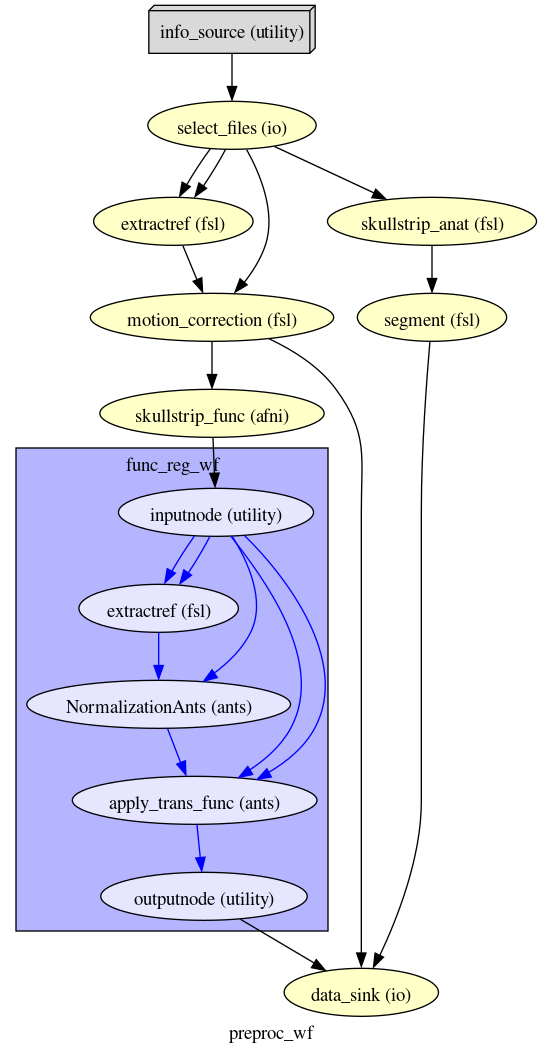

In [7]:
# Write graph of type colored
preproc_wf.write_graph(graph2use='colored', dotfilename='./graph_colored.dot')

# Visualize graph
from IPython.display import Image
Image(filename="graph_colored.png")

In [ ]:
preproc_wf.run()

230907-18:02:50,576 nipype.workflow INFO:
	 Workflow preproc_wf settings: ['check', 'execution', 'logging', 'monitoring']
230907-18:02:50,610 nipype.workflow INFO:
	 Running serially.
230907-18:02:50,611 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.select_files" in "/srv/tempdd/egermani/nguyen-etal-2021/outputs/preproc_wf/_subject_id_3107/select_files".
230907-18:02:50,631 nipype.workflow INFO:
	 [Node] Executing "select_files" <nipype.interfaces.io.SelectFiles>
230907-18:02:50,635 nipype.workflow INFO:
	 [Node] Finished "select_files", elapsed time 0.001699s.
230907-18:02:50,649 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.extractref" in "/srv/tempdd/egermani/nguyen-etal-2021/outputs/preproc_wf/_subject_id_3107/extractref".
230907-18:02:50,659 nipype.workflow INFO:
	 [Node] Cached "preproc_wf.extractref" - collecting precomputed outputs
230907-18:02:50,659 nipype.workflow INFO:
	 [Node] "preproc_wf.extractref" found cached.
230907-18:02:50,661 nipype.workflow INFO:
	

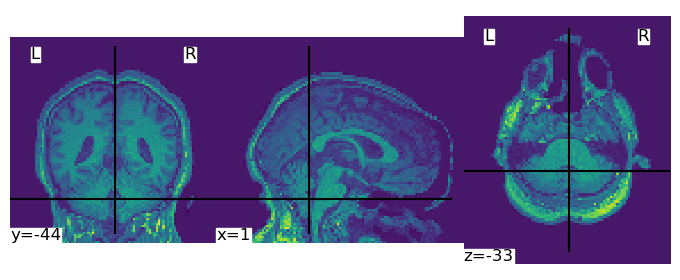

In [50]:
from nilearn import plotting, image
plotting.plot_img('./outputs/preproc_wf/_subject_id_3107/segment/sub-3107_T1w_masked_trans.nii.gz')